In [1]:
from gvuln import *
#from libSOGA import *
import matplotlib.pyplot as plt
from time import time

torch.set_default_dtype(torch.float32)

# Differential Privacy

### No DP

In [2]:
compiledFile=compile2SOGA('DP_nonoise.soga')
cfg = produce_cfg(compiledFile)

output_dist = start_SOGA(cfg)

marg_nonoise = extract_marginal(output_dist, ['dataset[0]', 'avg'])

vdelta_nonoise = vdelta_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=1)
vgauss_nonoise = vgauss_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], eps=1, idx_o=1)

gvd_nonoise = vdelta_nonoise.item()
gvg_nonoise = vgauss_nonoise.item()

gvd_nonoise, gvg_nonoise

(0.02102610468864441, 0.05263157933950424)

In [3]:
s_marg = extract_marginal(output_dist, ['dataset[0]'])
so_marg = extract_marginal(output_dist, ['dataset[0]', 'avg'])

entropy_nonoise = entropy_gaussian(s_marg.gm.mu[0], s_marg.gm.sigma[0])
cond_entropy_nonoise = cond_entropy_gaussian(so_marg.gm.mu[0], so_marg.gm.sigma[0], idx_o = [1])
mi_nonoise = mi_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=[1])

print('Entropy of secret: ', entropy_nonoise)
print('Entropy of secret given output: ', cond_entropy_nonoise)
print('MI between secret and output: ', mi_nonoise)

Entropy of secret:  tensor(4.4147)
Entropy of secret given output:  tensor(4.3620)
MI between secret and output:  0.05268049240112305


In [4]:
compiledFile=compile2SOGA('DP_nonoise_obs.soga')
cfg = produce_cfg(compiledFile)

output_dist_obs = start_SOGA(cfg)

s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

s_mu_obs = s_marg_obs.gm.mu[0]
s_sigma_obs = s_marg_obs.gm.sigma[0]
s_mu = s_marg.gm.mu[0]
s_sigma = s_marg.gm.sigma[0]

kl_nonoise = kl_div_gaussian(s_mu_obs, s_sigma_obs, s_mu, s_sigma)

print('KL divergenge between secret given output value and secret: ', kl_nonoise)


KL divergenge between secret given output value and secret:  0.007680241949856281


### Gaussian Mechanism

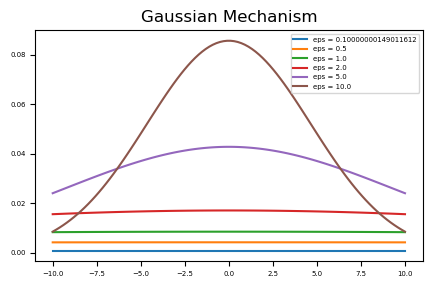

In [5]:
Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

plt.figure(figsize=(5, 3))

for eps in eps_list:

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    program = 'noise = gm([1.], [0.], [_std]);'
    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)

    x = torch.linspace(-10, 10, 100).reshape(100, 1)
    y = output_dist.gm.pdf(x).detach().numpy()
    plt.plot(x, y, label='eps = {}'.format(eps))

plt.title('Gaussian Mechanism')
plt.legend(fontsize=5)
plt.tick_params(axis='x', labelsize=5)
plt.tick_params(axis='y', labelsize=5)


In [6]:
Delta = 150/10
delta = 1/100
eps_list = [0.1, 0.5, 1., 2., 5., 10.]

gvd_gauss = {}   # g-vulnerability for delta gain
gvg_gauss = {}   # g-vulnerability for Gaussian gain
entropy_gauss = {}       # entropy of the secret variable
cond_entropy_gauss = {}  # conditional entropy of secret given output
mi_gauss = {}            # mutual information between secret and output
kl_gauss = {}        # KL divergence between secret given output value and secret 

for eps in eps_list:

    print('Eps: ', eps)

    eps = torch.tensor(eps)

    compiledFile=compile2SOGA('DP_Gauss.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    output_dist = start_SOGA(cfg, params_dict=params_dict)

    marg_gauss = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    s_marg_gauss = extract_marginal(output_dist, ['dataset[0]'])

    entropy_gauss['{}'.format(eps)] = entropy_gaussian(s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])
    cond_entropy_gauss['{}'.format(eps)] = cond_entropy_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    mi_gauss['{}'.format(eps)] = mi_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    gvd_gauss['{}'.format(eps)] =  vdelta_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=1).item()
    gvg_gauss['{}'.format(eps)] = vgauss_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], eps=1, idx_o=1).item()

    compiledFile=compile2SOGA('DP_Gauss_obs.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    s_marg_gauss_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

    kl_gauss['{}'.format(eps)] = kl_div_gaussian(s_marg_gauss_obs.gm.mu[0], s_marg_gauss_obs.gm.sigma[0], s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])


Eps:  0.1
Eps:  0.5
Eps:  1.0
Eps:  2.0
Eps:  5.0
Eps:  10.0


In [7]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, gvd_gauss[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, gvg_gauss[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, cond_entropy_gauss[key]))

print('\n Mutual Information   ')
for key in mi_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, mi_gauss[key]))

print('\n KL Divergence   ')
for key in kl_gauss.keys():
    print('\t Eps = {}, exact={}'.format(key, kl_gauss[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.10000000149011612, exact=0.019947297871112823
	 Eps = 0.5, exact=0.019951684400439262
	 Eps = 1.0, exact=0.019965168088674545
	 Eps = 2.0, exact=0.02001587487757206
	 Eps = 5.0, exact=0.02026909589767456
	 Eps = 10.0, exact=0.020626619458198547

 G-Vulnerability (Gauss Gain)
	 Eps = 0.10000000149011612, exact=0.04993807524442673
	 Eps = 0.5, exact=0.049949031323194504
	 Eps = 1.0, exact=0.049982700496912
	 Eps = 2.0, exact=0.05010933056473732
	 Eps = 5.0, exact=0.05074164271354675
	 Eps = 10.0, exact=0.051634300500154495

 Conditional Entropy   
	 Eps = 0.10000000149011612, exact=4.414661407470703
	 Eps = 0.5, exact=4.41444206237793
	 Eps = 1.0, exact=4.413766384124756
	 Eps = 2.0, exact=4.411229610443115
	 Eps = 5.0, exact=4.39865779876709
	 Eps = 10.0, exact=4.381173133850098

 Mutual Information   
	 Eps = 0.10000000149011612, exact=9.5367431640625e-06
	 Eps = 0.5, exact=0.0002288818359375
	 Eps = 1.0, exact=0.0009045600891113281
	 Eps = 2.0, e

### Laplacian Mechanism

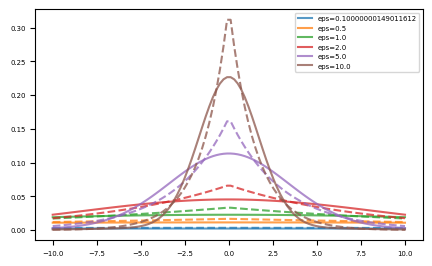

In [8]:
import matplotlib.pyplot as plt
from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

Delta = 150/10

eps_list = [0.1, 0.5, 1., 2., 5., 10.]

for eps in eps_list:

    eps = torch.tensor(eps)

    b = Delta/eps
    pi, mu1, mu2, sigma1, sigma2, _ = fit_laplace(torch.tensor(0.), b)

    program = 'v = gm([_p1, _p2], [_mean1, _mean2], [_sigma1, _sigma2]);'

    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)

    pars = {'p1': pi,
            'p2': 1-pi,
            'mean1': mu1,
            'mean2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value, requires_grad=True)    

    dist = start_SOGA(cfg, params_dict=params_dict)

    x = torch.linspace(-10, 10, 100).reshape(100, 1)
    y = dist.gm.pdf(x).detach().numpy()
    y_lap = Laplace(0., b).log_prob(x).exp().detach().numpy()

    color = next(color_cycle)
    plt.plot(x, y_lap, '--', color=color, alpha=0.75)
    plt.plot(x, y, label='eps={}'.format(eps.item()), color=color, alpha=0.75)

plt.legend(fontsize=5)
plt.tick_params(axis='x', labelsize=5)
plt.tick_params(axis='y', labelsize=5)
plt.show()


In [9]:
Delta = 150/10
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

gvd_lap_lb = {}
gvd_lap_ub = {}
gvg_lap_lb = {}
gvg_lap_ub = {}

gvd_lap = {}
gvg_lap = {}

cond_entropy_lap_lb = {}
cond_entropy_lap_ub = {}

mi_lap_lb = {}
mi_lap_ub = {}

kl_lap_lb = {}
kl_lap_ub = {}

sampling_time = 0.

for eps in eps_list:

    print('Eps: ', eps)

    # Approximating the Laplace
    b = Delta/eps

    pi, mu1, mu2, sigma1, sigma2, _ = fit_laplace(torch.tensor(0.), b)

    pars = {'p1': pi,
            'p2': 1-pi,
            'mean1': mu1,
            'mean2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value, requires_grad=True)    

    # Computing SOGA outputs
    compiledFile=compile2SOGA('DP_Laplace.soga')
    cfg = produce_cfg(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)

    compiledFile=compile2SOGA('DP_Laplace_obs.soga')
    cfg = produce_cfg(compiledFile)
    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    # Extracting marginals
    marg_lap = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    marg_lap = aggregate_mixture(marg_lap)
    s_marg = extract_marginal(output_dist, ['dataset[0]'])
    s_marg = aggregate_mixture(s_marg)
    s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    start = time()
    gvd_lap['{}'.format(eps)] = sample_gvuln(output_dist, 10000, gain_type='delta', secret_var='dataset[0]', output_var='avg')
    gvg_lap['{}'.format(eps)] = sample_gvuln(output_dist, 10000, gain_type='gauss', secret_var='dataset[0]', output_var='avg')
    end = time()
    sampling_time += end - start

    gvd_lap_lb['{}'.format(eps)] = vdelta_lower_bound(marg_lap, idx_o=1)
    gvd_lap_ub['{}'.format(eps)] = vdelta_upper_bound(marg_lap, idx_o=1)
    gvg_lap_lb['{}'.format(eps)] = vgauss_lower_bound(marg_lap, 1., idx_o=1)
    gvg_lap_ub['{}'.format(eps)] = vgauss_upper_bound(marg_lap, 1., idx_o=1)

    cond_entropy_lap_lb['{}'.format(eps)] = cond_entropy_lb(marg_lap, idx_o=[1])
    cond_entropy_lap_ub['{}'.format(eps)] = cond_entropy_ub(marg_lap, idx_o=[1])
    
    mi_lap_lb['{}'.format(eps)] = mi_lb(marg_lap, idx_o=[1])
    mi_lap_ub['{}'.format(eps)] = mi_ub(marg_lap, idx_o=[1])

    kl_lap_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_lap_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)

print('Sampling time: ', sampling_time)

Eps:  tensor(0.1000)
Eps:  tensor(0.5000)
Eps:  tensor(1.)
Eps:  tensor(2.)
Eps:  tensor(5.)
Eps:  tensor(10.)
Sampling time:  14.650619268417358


In [10]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_lap_lb.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, gvd_lap_lb[key], gvd_lap[key], gvg_lap_ub[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_lap_ub.keys():
    print('\t Eps = {}, lb = {}, exact={}, ub= {}'.format(key, gvg_lap_lb[key], gvg_lap[key], gvg_lap_ub[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_lap_ub.keys():
    print('\t Eps = {}, lb = {},ub= {}'.format(key, cond_entropy_lap_lb[key], cond_entropy_lap_ub[key]))

print('\n Mutual Information   ')
for key in mi_lap_ub.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, mi_lap_lb[key], mi_lap_ub[key]))

print('\n KL Divergence   ')
for key in kl_lap_ub.keys():
    print('\t Eps = {}, lb = {}, ub= {}'.format(key, kl_lap_lb[key], kl_lap_ub[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.10000000149011612, lb = 0.0186472125351429, exact=0.01919704768806696, ub= 0.049940939992666245
	 Eps = 0.5, lb = 0.018677912652492523, exact=0.01872189249843359, ub= 0.050018154084682465
	 Eps = 1.0, lb = 0.01876283809542656, exact=0.019820962101221085, ub= 0.050231896340847015
	 Eps = 2.0, lb = 0.018992915749549866, exact=0.01971388328820467, ub= 0.05081280693411827
	 Eps = 5.0, lb = 0.01941869780421257, exact=0.02012418769299984, ub= 0.051910147070884705
	 Eps = 10.0, lb = 0.019583003595471382, exact=0.020381108857691288, ub= 0.05237647891044617

 G-Vulnerability (Gauss Gain)
	 Eps = 0.10000000149011612, lb = 0.04668330401182175, exact=0.0474853590130806, ub= 0.049940939992666245
	 Eps = 0.5, lb = 0.04675997421145439, exact=0.04830606405933698, ub= 0.050018154084682465
	 Eps = 1.0, lb = 0.046972040086984634, exact=0.04765015095472336, ub= 0.050231896340847015
	 Eps = 2.0, lb = 0.04754655063152313, exact=0.04954274371266365, ub= 0.05081280693411

### Geometric Mechanism

In [11]:
# No Noise

compiledFile=compile2SOGA('DP_Geometric.soga')
cfg = produce_cfg(compiledFile)
dist = start_SOGA(cfg)

secret_var = 'dataset[0]'
output_var = 'count' 

discrete_V1(dist, secret_var, output_var)

tensor(0.6230)

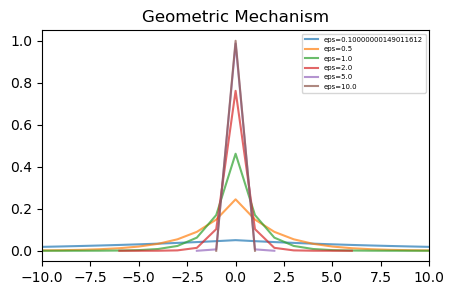

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))

for eps in eps_list:

    Delta = torch.tensor(1.)
    p = 1-torch.exp(-eps/Delta)

    str_gm = create_gm_from_p(p)

    program = 'geom1 = {}; \n geom2 = {}; \n geom = geom1 - geom2;'.format(str_gm, str_gm)

    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    dist = start_SOGA(cfg)

    marg = extract_marginal(dist, ['geom'])

    x = torch.unique(marg.gm.mu[:, 0])
    y = torch.zeros_like(x)
    for i in range(len(x)):
        mask = (marg.gm.mu[:, 0] == x[i])
        y[i] = torch.sum(marg.gm.pi[mask])

    # Plot the PMF
    plt.plot(x, y, alpha=0.7, label='eps={}'.format(eps))

plt.title(f'Geometric Mechanism')
plt.xlim(-10,10)
plt.legend(fontsize=5)
plt.show()



In [13]:
def discrete_kl(dist1, dist2, var):
    """
    Computes the discrete KL divergence between two distributions.
    """
    marg1 = extract_marginal(dist1, [var])
    marg2 = extract_marginal(dist2, [var])
    
    kl_value = torch.tensor([0.])

    supp1 = torch.unique(marg1.gm.mu[:, 0])
    supp2 = torch.unique(marg2.gm.mu[:, 0])
    supp = torch.unique(torch.cat((supp1, supp2)))
    
    for x in supp:
        mask1 = (marg1.gm.mu[:, 0] == x)
        p1 = marg1.gm.pi[mask1].sum()
        mask2 = (marg2.gm.mu[:, 0] == x)
        p2 = marg2.gm.pi[mask2].sum()
        if p1 > 0 and p2 > 0:
            kl_value += p1 * torch.log(p1 / p2)
    
    return kl_value.item()

In [14]:
eps_list = torch.tensor([0.5, 1., 2., 5., 10.])

gv_geom = {}
entropy_geom = {}
cond_entropy_geom = {}
mi_geom = {}
kl_geom = {}


for eps in eps_list:

    print('Eps: ', eps)

    # Approximating the geometric in the program
    Delta = torch.tensor(1.)
    p = 1 - torch.exp(-eps/Delta)
    gm_str = create_gm_from_p(p)

    program = '''array[10] dataset;

                for i in range(10){{
                    dataset[i] = gm([0.5,0.5], [0., 1.], [0.001, 0.001]);
                }} end for;
                count = 0.0;

                for i in range(10){{
                    count = count + dataset[i];
                }} end for;

                geom1 = {};
                geom2 = {}; 
                noise = geom1 - geom2;

                count = count + noise;
                '''.format(gm_str, gm_str)

    # computing SOGA outputs
    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg)
    #output_dist = aggregate_mixture(output_dist)

    program_obs = program + '\n observe(count == 2.);'
    compiledFile = compile2SOGA_text(program_obs)
    cfg = produce_cfg_text(compiledFile)
    output_dist_obs = start_SOGA(cfg)
    #output_dist_obs = aggregate_mixture(output_dist_obs)

    marg = extract_marginal(output_dist, ['dataset[0]'])
    marg = aggregate_mixture(marg)
    marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])
    marg_obs = aggregate_mixture(marg_obs)

    # Computing metrics
    gv_geom['{}'.format(eps)] = discrete_V1(output_dist, secret_var, output_var)    
    cond_entropy_geom['{}'.format(eps)] = discrete_cond_entropy(output_dist, secret_var, output_var)
    mi_geom['{}'.format(eps)] = discrete_mi(output_dist, secret_var, output_var)
    kl_geom['{}'.format(eps)] = discrete_kl(marg_obs, marg, secret_var)


Eps:  tensor(0.5000)
Eps:  tensor(1.)
Eps:  tensor(2.)
Eps:  tensor(5.)
Eps:  tensor(10.)


In [15]:
print('G-Vulnerability  ')
for key in gv_geom.keys():
    print('\t Eps = {},exact={}'.format(key, gv_geom[key]))


print('\n Conditional Entropy   ')
for key in cond_entropy_geom.keys():
    print('\t Eps = {}, exact = {}'.format(key, cond_entropy_geom[key]))

print('\n Mutual Information   ')
for key in mi_geom.keys():
    print('\t Eps = {}, exact = {}'.format(key, mi_geom[key]))

print('\n KL Divergence   ')
for key in kl_geom.keys():
    print('\t Eps = {}, exact = {}'.format(key, kl_geom[key]))



G-Vulnerability  
	 Eps = 0.5,exact=0.5739041566848755
	 Eps = 1.0,exact=0.6001512408256531
	 Eps = 2.0,exact=0.6165687441825867
	 Eps = 5.0,exact=0.6227676868438721
	 Eps = 10.0,exact=0.6230450868606567

 Conditional Entropy   
	 Eps = 0.5, exact = 0.6786220073699951
	 Eps = 1.0, exact = 0.6625507473945618
	 Eps = 2.0, exact = 0.6474385857582092
	 Eps = 5.0, exact = 0.6404736638069153
	 Eps = 10.0, exact = 0.6401236057281494

 Mutual Information   
	 Eps = 0.5, exact = 0.014525234699249268
	 Eps = 1.0, exact = 0.030596435070037842
	 Eps = 2.0, exact = 0.04570859670639038
	 Eps = 5.0, exact = 0.052673518657684326
	 Eps = 10.0, exact = 0.05302351713180542

 KL Divergence   
	 Eps = 0.5, exact = -0.19020679593086243
	 Eps = 1.0, exact = -0.16910308599472046
	 Eps = 2.0, exact = -0.14240539073944092
	 Eps = 5.0, exact = -0.12946391105651855
	 Eps = 10.0, exact = -0.12885503470897675
